<a href="https://colab.research.google.com/github/mahasiswateladan/emg/blob/main/EMG_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Electromyography Signal-based Gesture Recognition for Human-Machine Interaction

The main task of this project is to build a machine-learning model that can classify hand gestures in real-time. The model was created based on the LSTM, CNN-LSTM model and expanded to use Time2Vec  as feature encoding combined with Spacetimeformer Multivariate Forecasting.

In [185]:
!apt install subversion
!svn checkout https://github.com/mahasiswateladan/emg/trunk/dataset

Reading package lists... Done
Building dependency tree       
Reading state information... Done
subversion is already the newest version (1.9.7-4ubuntu1.1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
Checked out revision 2.


In [186]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import itertools
import os

import scipy as sc
import scipy.stats

%matplotlib inline 

## Dataset
The data used in this project is a public dataset from Kaggle. This dataset is the product of Christos Dolopikos, Michael Pritchard, Jordan J. Bird, Diego R. Faria " Electromyography Signal-based Gesture Recognition for Human-Machine Interaction in Real-Time through Model Calibration " Future of Information and Communications Conference (FICC), 2021. 

Data was collected using Myo Armband with a Bluetooth adapter connected to a computer. The connection is attained using Myo Python API, which enables the device's SDK and allows Python to access the armband. Python wrapper records forearm EMG data produced by muscle activity when executing a gesture for 60 seconds. Each EMG sensor in the Myo armband will read muscle activity as a signal that streams at 200Hz and represents an array containing eight integer values. The data from a single measurement session would save in a single CSV file with Unix Timestamp in every column.

Fifteen people will participate in the data collection (9 males and 6 females). For each person would wear the armband on their right forearm. The measuring procedure started after a brief demonstration of one of the required defined gestures: a closed fist, spread open fingers, waving inwards, and waving outwards. The subject was then instructed to perform this gesture repeatedly for 60 seconds, and to minimize the impact of random errors, five different repetitions per gesture were executed. Every person performed two different gestures and moved the hand for five minutes each.

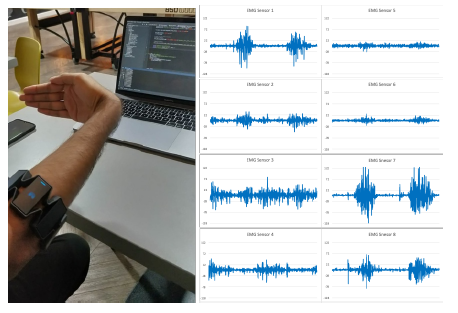



In [187]:
path = "dataset"
folder_dir = os.path.join(os.getcwd(), path)
dirlist = os.listdir(folder_dir)
print(folder_dir)
print(dirlist)

subjects = ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15']
gesturs = ['G1', 'G2', 'G3', 'G4']
channels = ['ch1', 'ch2', 'ch3', 'ch4', 'ch5', 'ch6', 'ch7', 'ch8']

/content/dataset
['.svn', 'P2', 'P8', 'P4', 'P9', 'P6', 'P3', 'P14', 'live', 'P7', 'P12', 'P10', 'P15', 'P13', 'P5', 'P1', 'P11']


## Data Preprocessing


1.   Data Cleaning 

    Although the subject performed the gesture for 60 seconds, it was found that due to variation in the participants' reaction times in initiating muscle movement when instructed, a portion at the start of each recording did not have any significant EMG activity. To address this, all data would be scanned and take the average of the participants' reaction times. After the value is found, it will cut the longer data and pad the short one with a 0 value so the data will have the same length. When the data cut, it's not haphazardly cut, but it will be cut from the front. It is because the portion at the start of each recording did not have any significant EMG activity.
    
2.   Rectification
    
    Raw EMG readings typically range from -128mV to +127mV for each timestamp and are highly oscillatory. By taking the absolute of all EMG values (all negative values become positive), the positive and negative values didn’t cancel out when calculating the mean of EMG values. Because for analysis, it is easier if the EMG signal were rectified into only positive values

3.   Feature Extraction
    
    Raw usage of the collected EMG data is not beneficial for machine learning due to the data's stochastic nature. EMG data, as previously mentioned, are bioelectric signals that are non-stationary, non-linear, and of random nature [5]. The sliding windows method was used to segment time series data into a collection of short pieces (1 seconds). The set of variables that were estimated from these signals are:
    

    *   mean(): Mean value
    *   std(): Standard deviation
    *   skewness(): skewness of the frequency domain signal 
    *   kurtosis(): kurtosis of the frequency domain signal 
    *   max(): Largest value in array
    *   min(): Smallest value in array
    *   Sample variances()
    *   Sample covariance()
    *   eigenvalues covariance
    *   upper triangular covariance
    *   magnitude of frequency components of each signal, obtained using a Fast Fourier Transform (FFT)




In [188]:
def slid_windows(df, time):
    nRow, nCol = df.shape
    row = 0
    windows = []

    for row in range(nRow // time-1):
        windows.append(df.iloc[row*time : (row+1)*time, 1:9])
    return windows

def plot_data(data):    
    channel = 1
    fig, axes = plt.subplots(2,4, figsize=(30, 8))
    for i in range(2):
        for j in range(4):
            axes[i][j].title.set_text("Channel "+ str(channel))
            axes[i][j].plot(data["timestamp"], data.iloc[:,channel])
            channel = channel + 1

def avg_time(subjects, gesturs, path):
    times = []

    for subject in subjects:
        for gestur in gesturs:
            gesture_dir = os.path.join(os.path.join(path, subject), gestur)
            gesture_dirlist = os.listdir(gesture_dir)

            for dfame in gesture_dirlist:
                dfame_dir = os.path.join(os.path.join(os.path.join(path, subject), gestur), dfame)
                df = pd.read_csv(dfame_dir)

                # sliding windows for 1s
                # 1 sec = 200 row
                sec_1 = 200
                windows = slid_windows(df, sec_1)
                times.append(len(windows))

    # print(np.round(np.mean(times)))
    return int(np.round(np.mean(times)))

def bandpass_filter():
    # create bandpass filter for EMG
    high = 20/(1000/2)
    low = 150/(1000/2)
    b, a = sc.signal.butter(4, [high,low], btype='bandpass')
    
    # process EMG signal: filter EMG
    emg_filtered = sc.signal.filtfilt(b, a, df['ch1'])

    return emg_filtered

In [189]:
## FIRST EXAMPLE
# 300 x 60 x [64 x 8]
def ex_feature(windows):
    windows_feature = []
    final_windows_feature = []
    # print(windows_feature)

    for window in windows:
        windows_feature = []
        for ch in range(len(channels)):
            window_feature = []
            data = window[:,ch]

            # Mean and Standard deviation of the wave
            window_feature.append(data.mean())
            window_feature.append(data.std())
            # print(f'Mean: {data.mean()}, STD: {data.std()}')

            # Skewness and Kurtosis
            # window_feature.append(window[ch].skew())
            window_feature.append(sc.stats.skew(data))
            window_feature.append(sc.stats.kurtosis(data))
            # print(f'Skew: {sc.stats.skew(data)}, Kurtosis: {sc.stats.kurtosis(data)}')

            # Maximum and minimum values
            window_feature.append(data.max())
            window_feature.append(data.min())
            # print(f'Max: {data.max()}, Min: {data.min()}')

            # Sample variances of each wave, plus the sample covariances of all pairs of the waves
            cov = np.cov(data, bias=False)
            window_feature.append(data.var())
            window_feature.append(cov)
            # print(f'Variance: {data.var()}, Covariance: {cov}')

            # The eigenvalues of the covariance matrix
            # e_val, e_vec = np.linalg.eig(cov)
            # window_feature.append(e_val)
            # print(f'Eigenvalues: {e_val}')

            # The upper triangular elements of the matrix logarithm of the covariance matrix
            # window_feature.append(np.triu(cov))
            # print(f'Upper triangular: {np.triu(cov)}')
            
            # The magnitude of frequency components of each signal, obtained using a Fast Fourier Transform (FFT)
            fft_ch = np.fft.rfft(data)
            magnitude = np.abs(fft_ch)
            window_feature += list(np.concatenate([window_feature, magnitude]))
            # print(f'FFT: {list(np.concatenate([window_feature, magnitude]))}')

            windows_feature.append(window_feature)
        final_windows_feature.append(np.array(windows_feature).transpose())
    return final_windows_feature

In [190]:
# Calculate the average of the participant reaction times
time = avg_time(subjects, gesturs, path)
print(f'Average participant reaction times: {time} seconds')

Average participant reaction times: 96 seconds


In [191]:
# Read all RAW EMG data
all_feat = []
all_feat_rec = []
all_ges = []
stat_rec_data_pad = 0
stat_rec_data_cut = 0 

for subject in subjects:
    for gestur in gesturs:
        gesture_dir = os.path.join(os.path.join(path, subject), gestur)
        gesture_dirlist = os.listdir(gesture_dir)
        # print(gesture_dirlist)
        # gesture_dirlist = ['P1-fist-T5.csv']

        for dfame in gesture_dirlist:
            dfame_dir = os.path.join(os.path.join(os.path.join(path, subject), gestur), dfame)
            df = pd.read_csv(dfame_dir)
            df_rec = abs(df)                        # Rectification the EMG data

            # Save for Plot
            if (dfame == 'P1-fist-T1.csv'):
                raw_data = df                  

            # padding
            # sliding windows for 1s
            # 1 sec = 200 row
            sec_1 = 200
            pad_windows = np.zeros((time, 200, 8))
            pad_windows_rec = np.zeros((time, 200, 8))                  # Rectification the EMG data
            windows = np.array(slid_windows(df, sec_1))
            windows_rec = np.array(slid_windows(df_rec, sec_1))         # Rectification the EMG data
            
            if len(windows) < time:
                for i in range(len(windows)):
                    pad_windows[i] = windows[i]
                    pad_windows_rec[i] = windows_rec[i]                 # Rectification the EMG data
                    
                # Save for Plot
                if (stat_rec_data_pad == 0):
                    rec_data_pad = pad_windows
                    stat_rec_data_pad = 1
            else:
                for i in range(len(pad_windows)):
                    pad_windows[len(pad_windows)-(i+1)] = windows[len(windows)-(i+1)]
                    pad_windows_rec[len(pad_windows)-(i+1)] = windows_rec[len(windows)-(i+1)]       # Rectification the EMG data
                    
                # Save for Plot
                if (stat_rec_data_cut == 0):
                    rec_data_cut = pad_windows
                    stat_rec_data_cut = 1
            
            # Save for Plot
            if (dfame == 'P1-fist-T1.csv'):
                rec_data = abs(pad_windows)              # Rectification the EMG data
            
            # Extract the feature
            windows_feature = ex_feature(pad_windows)
            all_feat.append(windows_feature)

            # Extract the feature Rectification the EMG data
            windows_feature = ex_feature(pad_windows_rec)
            all_feat_rec.append(windows_feature)

            # Label
            if(gestur == "G1"):
                all_ges.append(0)
            elif(gestur == "G2"):
                all_ges.append(1)
            elif(gestur == "G3"):
                all_ges.append(2)
            else:
                all_ges.append(3)
# all_feat = np.dstack(all_feat)

In [192]:
print(f'RAW EMG data: {np.shape(raw_data)}')

RAW EMG data: (21430, 10)


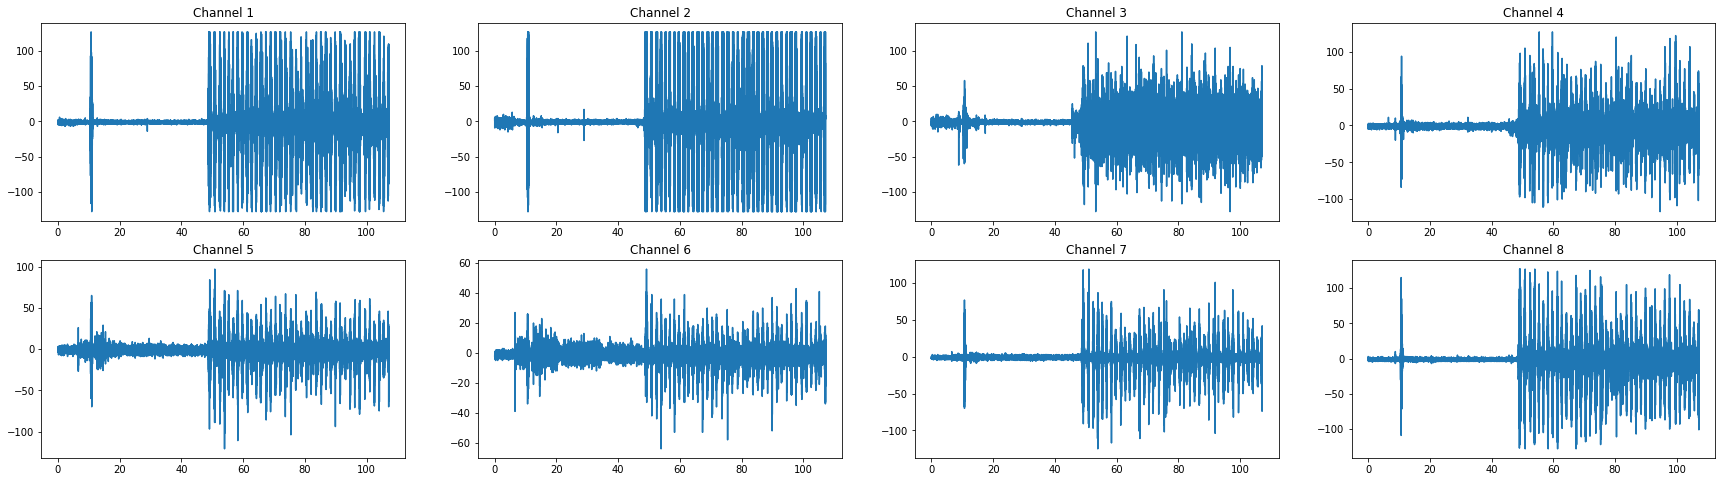

In [193]:
plot_data(raw_data)

In [194]:
print(f'RAW EMG data after pad: {np.shape(rec_data_pad)}')
print(f'RAW EMG data after cut: {np.shape(rec_data_cut)}')

RAW EMG data after pad: (96, 200, 8)
RAW EMG data after cut: (96, 200, 8)


In [195]:
rec_data_cut_reshape = rec_data_cut.reshape((rec_data_cut.shape[0]*rec_data_cut.shape[1], rec_data_cut.shape[2]))
print(rec_data_cut_reshape.shape)

(19200, 8)


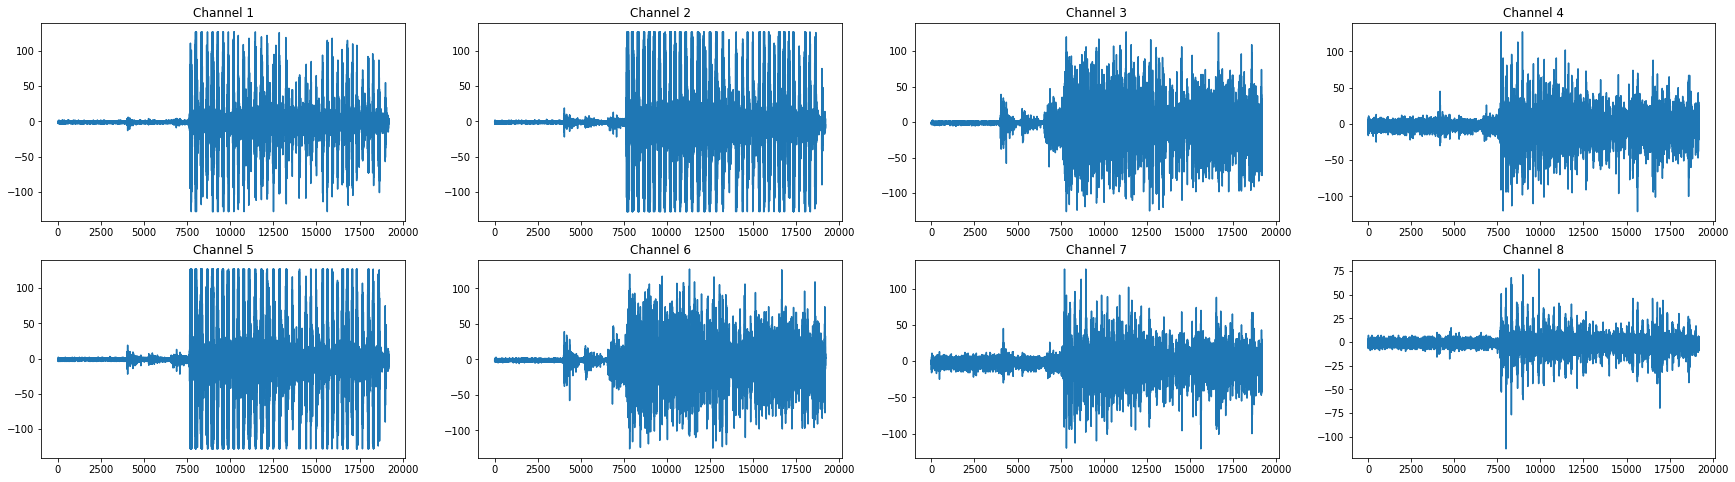

In [196]:
channel = 1
fig, axes = plt.subplots(2,4, figsize=(30, 8))
for i in range(2):
    for j in range(4):
        axes[i][j].title.set_text("Channel "+ str(channel))
        axes[i][j].plot(np.arange(len(rec_data_cut_reshape)), rec_data_cut_reshape[:,i+j])
        channel = channel + 1

In [197]:
rec_data_pad_reshape = rec_data_pad.reshape((rec_data_pad.shape[0]*rec_data_pad.shape[1], rec_data_pad.shape[2]))
print(rec_data_pad_reshape.shape)

(19200, 8)


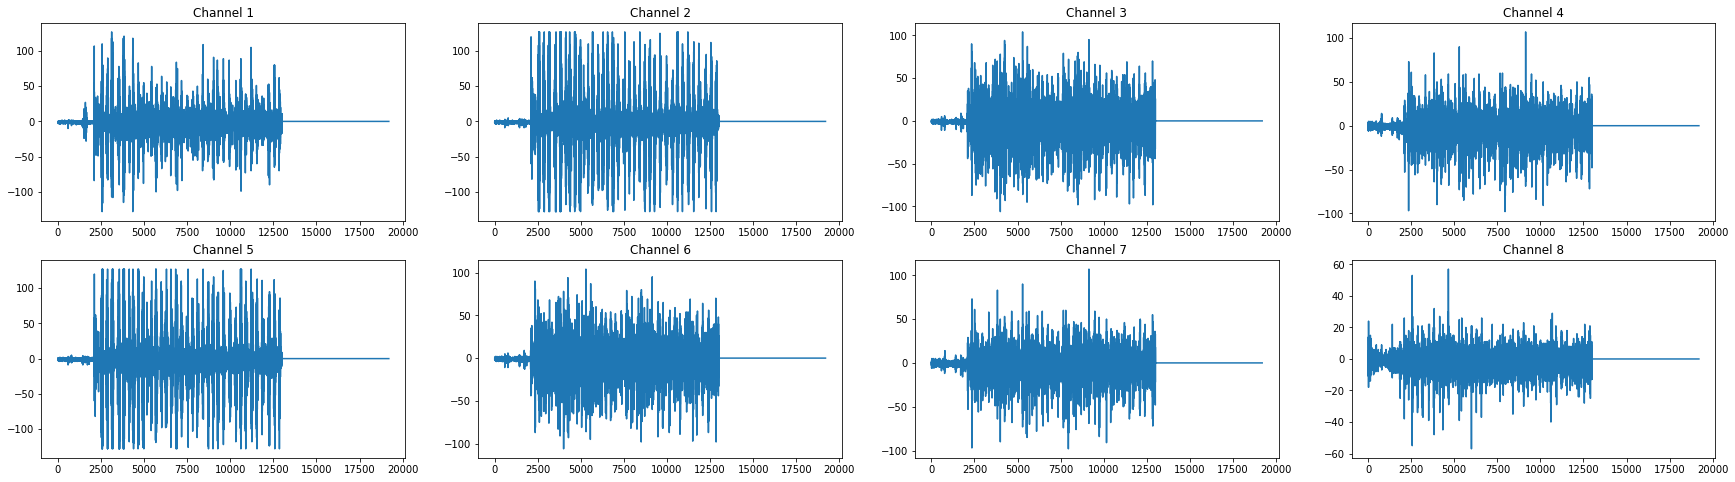

In [198]:
channel = 1
fig, axes = plt.subplots(2,4, figsize=(30, 8))
for i in range(2):
    for j in range(4):
        axes[i][j].title.set_text("Channel "+ str(channel))
        axes[i][j].plot(np.arange(len(rec_data_pad_reshape)), rec_data_pad_reshape[:,i+j])
        channel = channel + 1

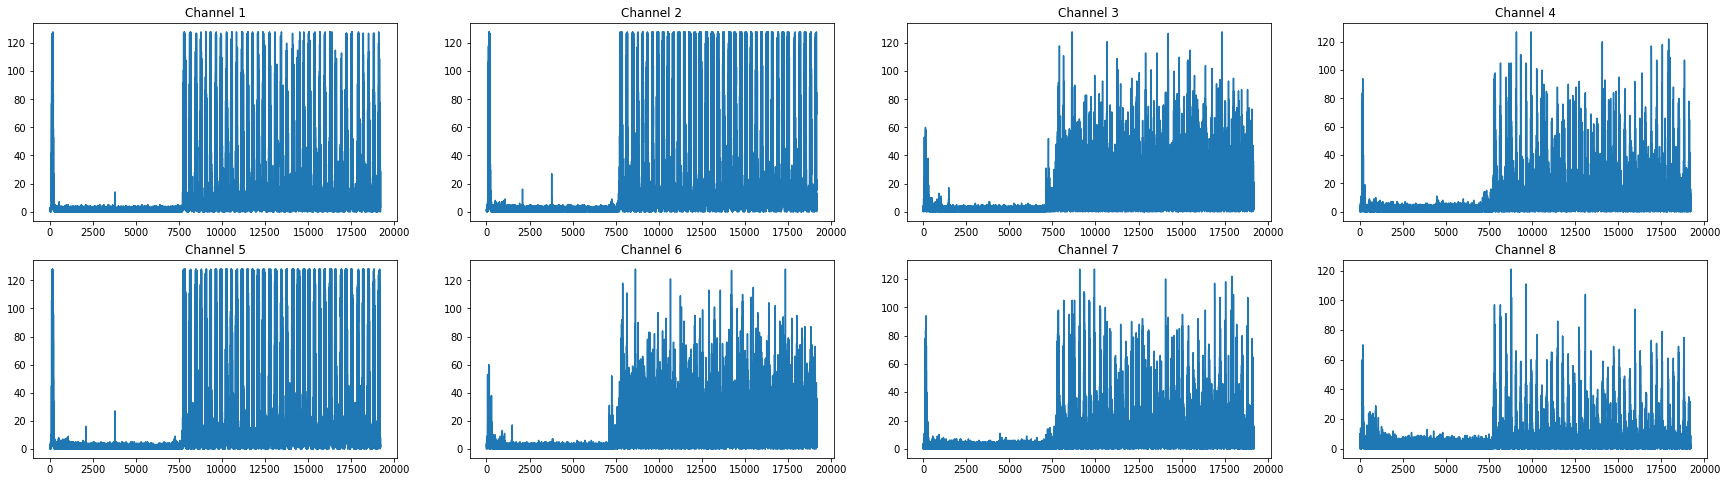

In [199]:
# plot_data(rec_data)
rec_data_reshape = rec_data.reshape((rec_data.shape[0]*rec_data.shape[1], rec_data.shape[2]))
channel = 1
fig, axes = plt.subplots(2,4, figsize=(30, 8))
for i in range(2):
    for j in range(4):
        axes[i][j].title.set_text("Channel "+ str(channel))
        axes[i][j].plot(np.arange(len(rec_data_reshape)), rec_data_reshape[:,i+j])
        channel = channel + 1


In [200]:
print(f'Feature size: {np.shape(all_feat)}, Label size: {np.shape(all_ges)}')
print(f'Rectification Feature size: {np.shape(all_feat_rec)}, Label size: {np.shape(all_ges)}')

Feature size: (300, 96, 117, 8), Label size: (300,)
Rectification Feature size: (300, 96, 117, 8), Label size: (300,)


## Experiment

In [201]:
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam

In [202]:
X = np.array(all_feat)
X_rec = np.array(all_feat_rec)          # Rectification the EMG data
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]*X.shape[3]))
X_rec = X_rec.reshape((X_rec.shape[0], X_rec.shape[1], X_rec.shape[2]*X_rec.shape[3]))  # Rectification the EMG data
y = to_categorical(np.array(all_ges))
print(f'Feature shape: {X.shape}, Label shape: {y.shape}')
print(X.min().round(5), X.max().round(5))
print(f'Feature shape: {X_rec.shape}, Label shape: {y.shape}')
print(X_rec.min().round(5), X_rec.max().round(5))

Feature shape: (300, 96, 936), Label shape: (300, 4)
-128.0 6969.43153
Feature shape: (300, 96, 936), Label shape: (300, 4)
-3.0 14313.0


In [203]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaler = scaler.fit_transform(X.reshape(X.shape[0], -1)).reshape(X.shape)
X_rec_scaler = scaler.fit_transform(X_rec.reshape(X_rec.shape[0], -1)).reshape(X_rec.shape)     # Rectification the EMG data

print(f'Feature shape: {X_scaler.shape}, Label shape: {y.shape}')
print(X_scaler.min().round(5), X_scaler.max().round(5)) # -1, 1
print(f'Feature shape: {X_rec_scaler.shape}, Label shape: {y.shape}')       # Rectification the EMG data
print(X_rec_scaler.min().round(5), X_rec_scaler.max().round(5)) # -1, 1

Feature shape: (300, 96, 936), Label shape: (300, 4)
-1.0 1.0
Feature shape: (300, 96, 936), Label shape: (300, 4)
-1.0 1.0


In [204]:
# Normal EMG dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaler, y, test_size=0.2)
print(f'X_tr: {np.shape(X_train)}, y_tr: {np.shape(y_train)}, X_ts: {np.shape(X_test)}, y_ts: {np.shape(y_test)}')

X_tr: (240, 96, 936), y_tr: (240, 4), X_ts: (60, 96, 936), y_ts: (60, 4)


In [205]:
n_sample = X_train.shape[0]
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = y_train.shape[1]
input_shape = (n_timesteps, n_features)

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(n_outputs, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 96, 128)           545280    
                                                                 
 lstm_7 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 594,948
Trainable params: 594,948
Non-trainable params: 0
_________________________________________________________________


In [206]:
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

Epoch 1/50
8/8 - 7s - loss: 1.4190 - accuracy: 0.2417 - 7s/epoch - 920ms/step
Epoch 2/50
8/8 - 2s - loss: 1.3606 - accuracy: 0.3625 - 2s/epoch - 290ms/step
Epoch 3/50
8/8 - 2s - loss: 1.3209 - accuracy: 0.3875 - 2s/epoch - 290ms/step
Epoch 4/50
8/8 - 2s - loss: 1.2722 - accuracy: 0.4458 - 2s/epoch - 292ms/step
Epoch 5/50
8/8 - 2s - loss: 1.1883 - accuracy: 0.5833 - 2s/epoch - 298ms/step
Epoch 6/50
8/8 - 2s - loss: 1.1441 - accuracy: 0.5417 - 2s/epoch - 287ms/step
Epoch 7/50
8/8 - 2s - loss: 1.0722 - accuracy: 0.6042 - 2s/epoch - 290ms/step
Epoch 8/50
8/8 - 2s - loss: 0.9962 - accuracy: 0.6583 - 2s/epoch - 291ms/step
Epoch 9/50
8/8 - 2s - loss: 0.9278 - accuracy: 0.6417 - 2s/epoch - 292ms/step
Epoch 10/50
8/8 - 2s - loss: 0.8572 - accuracy: 0.6875 - 2s/epoch - 293ms/step
Epoch 11/50
8/8 - 2s - loss: 0.8129 - accuracy: 0.6750 - 2s/epoch - 290ms/step
Epoch 12/50
8/8 - 2s - loss: 0.7238 - accuracy: 0.6875 - 2s/epoch - 293ms/step
Epoch 13/50
8/8 - 2s - loss: 0.6920 - accuracy: 0.7125 - 2s/e

In [207]:
_, accuracy = model.evaluate(X_test, y_test, batch_size=32, verbose=2)
accuracy = accuracy * 100.0
print(accuracy)

2/2 - 1s - loss: 0.4251 - accuracy: 0.8333 - 1s/epoch - 571ms/step
83.33333134651184


In [208]:
from tensorflow.keras.layers import Conv1D, TimeDistributed, MaxPool1D, Flatten

In [209]:
n_steps, n_length = 3, 32
trainX = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
testX = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))

In [210]:
model_cnn = Sequential()
model_cnn.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None, n_length, n_features)))
model_cnn.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model_cnn.add(TimeDistributed(Dropout(0.5)))
model_cnn.add(TimeDistributed(MaxPool1D(pool_size=2)))
model_cnn.add(TimeDistributed(Flatten()))
model_cnn.add(LSTM(100))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(100, activation='relu'))
model_cnn.add(Dense(n_outputs, activation='softmax'))
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, None, 30, 64)     179776    
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, None, 28, 64)     12352     
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 28, 64)     0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, None, 14, 64)     0         
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, None, 896)       

In [211]:
# fit network
model_cnn.fit(trainX, y_train, epochs=50, batch_size=32, verbose=2)


Epoch 1/50
8/8 - 3s - loss: 1.4504 - accuracy: 0.2833 - 3s/epoch - 360ms/step
Epoch 2/50
8/8 - 1s - loss: 1.3999 - accuracy: 0.3167 - 576ms/epoch - 72ms/step
Epoch 3/50
8/8 - 1s - loss: 1.4281 - accuracy: 0.2500 - 564ms/epoch - 70ms/step
Epoch 4/50
8/8 - 1s - loss: 1.4421 - accuracy: 0.2708 - 581ms/epoch - 73ms/step
Epoch 5/50
8/8 - 1s - loss: 1.4441 - accuracy: 0.2625 - 559ms/epoch - 70ms/step
Epoch 6/50
8/8 - 1s - loss: 1.4151 - accuracy: 0.2667 - 580ms/epoch - 72ms/step
Epoch 7/50
8/8 - 1s - loss: 1.4058 - accuracy: 0.2958 - 594ms/epoch - 74ms/step
Epoch 8/50
8/8 - 1s - loss: 1.4321 - accuracy: 0.2500 - 563ms/epoch - 70ms/step
Epoch 9/50
8/8 - 1s - loss: 1.3958 - accuracy: 0.2833 - 578ms/epoch - 72ms/step
Epoch 10/50
8/8 - 1s - loss: 1.4012 - accuracy: 0.2625 - 568ms/epoch - 71ms/step
Epoch 11/50
8/8 - 1s - loss: 1.4193 - accuracy: 0.2125 - 583ms/epoch - 73ms/step
Epoch 12/50
8/8 - 1s - loss: 1.4072 - accuracy: 0.2458 - 578ms/epoch - 72ms/step
Epoch 13/50
8/8 - 1s - loss: 1.4038 - a

In [212]:
 # evaluate model
_, accuracy = model_cnn.evaluate(testX, y_test, batch_size=32, verbose=2)
accuracy = accuracy * 100.0 
print(accuracy)

2/2 - 1s - loss: 1.1004 - accuracy: 0.5167 - 634ms/epoch - 317ms/step
51.66666507720947


In [213]:
# Rectification EMG dataset
X_train, X_test, y_train, y_test = train_test_split(X_rec_scaler, y, test_size=0.2)
print(f'X_tr: {np.shape(X_train)}, y_tr: {np.shape(y_train)}, X_ts: {np.shape(X_test)}, y_ts: {np.shape(y_test)}')

X_tr: (240, 96, 936), y_tr: (240, 4), X_ts: (60, 96, 936), y_ts: (60, 4)


In [214]:
n_sample = X_train.shape[0]
n_timesteps = X_train.shape[1]
n_features = X_train.shape[2]
n_outputs = y_train.shape[1]
input_shape = (n_timesteps, n_features)

# create and fit the LSTM network
model_rec = Sequential()
model_rec.add(LSTM(128, input_shape=input_shape, return_sequences=True))
model_rec.add(LSTM(64))
model_rec.add(Dropout(0.2))
model_rec.add(Dense(n_outputs, activation='softmax'))
model_rec.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])
model_rec.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 96, 128)           545280    
                                                                 
 lstm_10 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 4)                 260       
                                                                 
Total params: 594,948
Trainable params: 594,948
Non-trainable params: 0
_________________________________________________________________


In [215]:
model_rec.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

Epoch 1/50
8/8 - 6s - loss: 1.4248 - accuracy: 0.2583 - 6s/epoch - 744ms/step
Epoch 2/50
8/8 - 2s - loss: 1.3522 - accuracy: 0.3042 - 2s/epoch - 299ms/step
Epoch 3/50
8/8 - 2s - loss: 1.3201 - accuracy: 0.3708 - 2s/epoch - 291ms/step
Epoch 4/50
8/8 - 2s - loss: 1.2726 - accuracy: 0.4667 - 2s/epoch - 295ms/step
Epoch 5/50
8/8 - 2s - loss: 1.2120 - accuracy: 0.5125 - 2s/epoch - 300ms/step
Epoch 6/50
8/8 - 2s - loss: 1.1513 - accuracy: 0.5542 - 2s/epoch - 293ms/step
Epoch 7/50
8/8 - 2s - loss: 1.0544 - accuracy: 0.6500 - 2s/epoch - 296ms/step
Epoch 8/50
8/8 - 2s - loss: 1.0034 - accuracy: 0.6583 - 2s/epoch - 294ms/step
Epoch 9/50
8/8 - 2s - loss: 0.9993 - accuracy: 0.6167 - 2s/epoch - 294ms/step
Epoch 10/50
8/8 - 2s - loss: 0.9208 - accuracy: 0.7375 - 2s/epoch - 299ms/step
Epoch 11/50
8/8 - 2s - loss: 0.8464 - accuracy: 0.7083 - 2s/epoch - 296ms/step
Epoch 12/50
8/8 - 2s - loss: 0.8193 - accuracy: 0.7292 - 2s/epoch - 295ms/step
Epoch 13/50
8/8 - 2s - loss: 0.7658 - accuracy: 0.7375 - 2s/e

In [216]:
_, accuracy = model_rec.evaluate(X_test, y_test, batch_size=32, verbose=2)
accuracy = accuracy * 100.0
print(accuracy)

2/2 - 1s - loss: 0.4526 - accuracy: 0.8167 - 1s/epoch - 575ms/step
81.66666626930237


In [217]:
n_steps, n_length = 3, 32
trainX = X_train.reshape((X_train.shape[0], n_steps, n_length, n_features))
testX = X_test.reshape((X_test.shape[0], n_steps, n_length, n_features))

In [218]:
model_cnn_rec = Sequential()
model_cnn_rec.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu'), input_shape=(None, n_length, n_features)))
model_cnn_rec.add(TimeDistributed(Conv1D(filters=64, kernel_size=3, activation='relu')))
model_cnn_rec.add(TimeDistributed(Dropout(0.5)))
model_cnn_rec.add(TimeDistributed(MaxPool1D(pool_size=2)))
model_cnn_rec.add(TimeDistributed(Flatten()))
model_cnn_rec.add(LSTM(100))
model_cnn_rec.add(Dropout(0.5))
model_cnn_rec.add(Dense(100, activation='relu'))
model_cnn_rec.add(Dense(n_outputs, activation='softmax'))
model_cnn_rec.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_cnn_rec.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_5 (TimeDis  (None, None, 30, 64)     179776    
 tributed)                                                       
                                                                 
 time_distributed_6 (TimeDis  (None, None, 28, 64)     12352     
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, None, 28, 64)     0         
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, None, 14, 64)     0         
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, None, 896)       

In [219]:
# fit network
model_cnn_rec.fit(trainX, y_train, epochs=50, batch_size=32, verbose=2)


Epoch 1/50
8/8 - 3s - loss: 1.4236 - accuracy: 0.2542 - 3s/epoch - 359ms/step
Epoch 2/50
8/8 - 1s - loss: 1.4117 - accuracy: 0.2792 - 583ms/epoch - 73ms/step
Epoch 3/50
8/8 - 1s - loss: 1.4205 - accuracy: 0.2833 - 580ms/epoch - 72ms/step
Epoch 4/50
8/8 - 1s - loss: 1.4462 - accuracy: 0.2250 - 595ms/epoch - 74ms/step
Epoch 5/50
8/8 - 1s - loss: 1.4306 - accuracy: 0.2125 - 567ms/epoch - 71ms/step
Epoch 6/50
8/8 - 1s - loss: 1.3644 - accuracy: 0.3167 - 589ms/epoch - 74ms/step
Epoch 7/50
8/8 - 1s - loss: 1.4216 - accuracy: 0.2292 - 570ms/epoch - 71ms/step
Epoch 8/50
8/8 - 1s - loss: 1.3880 - accuracy: 0.2792 - 582ms/epoch - 73ms/step
Epoch 9/50
8/8 - 1s - loss: 1.4065 - accuracy: 0.2708 - 574ms/epoch - 72ms/step
Epoch 10/50
8/8 - 1s - loss: 1.4075 - accuracy: 0.2167 - 578ms/epoch - 72ms/step
Epoch 11/50
8/8 - 1s - loss: 1.3799 - accuracy: 0.2708 - 600ms/epoch - 75ms/step
Epoch 12/50
8/8 - 1s - loss: 1.3927 - accuracy: 0.2292 - 573ms/epoch - 72ms/step
Epoch 13/50
8/8 - 1s - loss: 1.3846 - a

In [220]:
 # evaluate model
_, accuracy = model_cnn_rec.evaluate(testX, y_test, batch_size=32, verbose=2)
accuracy = accuracy * 100.0 
print(accuracy)

2/2 - 1s - loss: 0.7145 - accuracy: 0.7500 - 649ms/epoch - 325ms/step
75.0
